In [ ]:
# In this notebook, we will perform Word Cloud Analytics

In [1]:
# Webscraping
from bs4 import BeautifulSoup
import requests
import re
import datetime
import pandas as pd
from datetime import datetime
from selenium import webdriver
from selenium.webdriver.support.ui import Select
import time

# Databases
from elasticsearch_dsl import Document, Text, Date, Integer
from elasticsearch_dsl.connections import connections
from elasticsearch import Elasticsearch
from elasticsearch_dsl import Search, Q

# Text Analytics
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import nltk
from nltk import FreqDist, SnowballStemmer
import string
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.util import ngrams

# Word Cloud
import wordcloud
from wordcloud import WordCloud, ImageColorGenerator
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

# Charting
import matplotlib
import matplotlib.pyplot as plt
from sklearn import linear_model

In [ ]:
### Word Cloud Analytics

In [2]:
def remove_emoji(txt):
    emoji_patterns = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                                u"\🥰"
                           "]+", flags=re.UNICODE)
    
    return emoji_patterns.sub(r'', txt)

def myPrep(text):
    tokens = nltk.word_tokenize(remove_emoji(text.lower()))
    tokens = [ t for t in tokens if t not in string.punctuation+"’“”" ]
    tokens = [ t for t in tokens if t not in stopword_list ]
    tokens = [ t for t in tokens if not t.isnumeric() ]
    #tokens = [ snowball.stem(t) for t in tokens ]
    tokens = [ lemm.lemmatize(t) for t in tokens ]
    
    # for bigrams
    tokens = list(nltk.bigrams(tokens))
    tokens = [' '.join(tup) for tup in tokens]
    
    # for trigrams
    #tokens = ngrams(tokens, 3)
    #tokens = [' '.join(tup) for tup in tokens]
    
    return tokens

In [3]:
stopword_list = stopwords.words('english') + ['would', 'could']
snowball = SnowballStemmer('english')
lemm = WordNetLemmatizer()

In [7]:
# Define a default Elasticsearch client
client = connections.create_connection(hosts=['localhost:9200'])

In [8]:
# Get list of all restaurant ids that have reviews
s = Search(using=client, index="tripadvisor-reviews", doc_type="_doc")

body = {
  "aggs": {
    "agg_rest_id": {
      "terms": {
        "field": "rest_id.keyword",
        "size": 10000
      }
    }
  }
}

s = Search.from_dict(body)
s = s.index("tripadvisor-reviews")
s = s.doc_type("_doc")

body = s.to_dict()
t = s.execute()

list_of_review_ids = []
for item in t.aggregations.agg_rest_id.buckets:
    list_of_review_ids.append(item.key)

len(list_of_review_ids)

C:\Users\Sam\Anaconda3\lib\site-packages\elasticsearch\connection\base.py:209: ElasticsearchWarning: Elasticsearch built-in security features are not enabled. Without authentication, your cluster could be accessible to anyone. See https://www.elastic.co/guide/en/elasticsearch/reference/7.15/security-minimal-setup.html to enable security.
  warnings.warn(message, category=ElasticsearchWarning)


254

In [9]:
es = Elasticsearch("localhost:9200", timeout=60, max_retries=10, retry_on_timeout=True)

top200_tokenized_by_rest_id = []
bottom200_tokenized_by_rest_id = []

for x in list_of_review_ids:
    combined_string = ""
    restaurant_rank = 0
    
    res = es.search(index="tripadvisor-reviews", doc_type='_doc', body={"query":{"match": {"rest_id": x}}}, size=10000)
    
    for hit in res['hits']['hits']:
        combined_string += hit['_source']['review_comment']
        combined_string += ' '
        restaurant_rank = hit['_source']['rank']
        rest_id = hit['_source']['rest_id']
    
    if rest_id != 'd9752334':
    
        if restaurant_rank <= 188 :
            top200_tokenized_by_rest_id.append(myPrep(combined_string))
        else:
            bottom200_tokenized_by_rest_id.append(myPrep(combined_string))

C:\Users\Sam\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: DeprecationWarning: The 'body' parameter is deprecated for the 'search' API and will be removed in 8.0.0. Instead use API parameters directly. See https://github.com/elastic/elasticsearch-py/issues/1698 for more information
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Sam\Anaconda3\lib\site-packages\elasticsearch\connection\base.py:209: ElasticsearchWarning: [types removal] Specifying types in search requests is deprecated.
  warnings.warn(message, category=ElasticsearchWarning)


In [10]:
## Single Token
FreqDist(top200_tokenized_by_rest_id[0]).most_common(50)

[('melt cafe', 153),
 ('great service', 74),
 ('service staff', 64),
 ('excellent service', 56),
 ('food good', 49),
 ('good service', 44),
 ('mandarin oriental', 41),
 ('come back', 37),
 ('dining experience', 35),
 ('food great', 35),
 ('food service', 30),
 ('service ck', 27),
 ('staff friendly', 26),
 ('friendly attentive', 24),
 ('service great', 24),
 ('special thanks', 24),
 ('breakfast melt', 24),
 ('definitely come', 23),
 ('good food', 22),
 ('lunch buffet', 21),
 ('customer service', 20),
 ('mr ganesan', 20),
 ('service excellent', 20),
 ('variety food', 20),
 ('great food', 20),
 ('service good', 19),
 ('served u', 19),
 ('staff ck', 19),
 ('attentive need', 19),
 ('quality food', 18),
 ('attentive service', 18),
 ('keep good', 18),
 ('birthday cake', 17),
 ('ck ganesan', 17),
 ('staff attentive', 17),
 ('food quality', 17),
 ('experience melt', 17),
 ('good work', 17),
 ('ck attentive', 17),
 ('food excellent', 16),
 ('ice cream', 16),
 ('service crew', 16),
 ('indian food

In [11]:
FreqDist(bottom200_tokenized_by_rest_id[0]).most_common(50)

[('door door', 10),
 ('bought voucher', 9),
 ('door sale', 7),
 ('order food', 7),
 ('food cold', 7),
 ('food delivered', 6),
 ('food arrive', 6),
 ('food quality', 6),
 ('welcome bonus', 6),
 ('day advance', 6),
 ('place order', 5),
 ('bought coupon', 5),
 ('butter chicken', 5),
 ('first order', 5),
 ('tom yum', 5),
 ('yum soup', 5),
 ('delivery time', 5),
 ('food arrived', 5),
 ('missing item', 5),
 ('food delivery', 5),
 ('quality food', 4),
 ('delivery food', 4),
 ('next day', 4),
 ('even though', 4),
 ('time food', 4),
 ('bad experience', 4),
 ('cereal prawn', 4),
 ('food really', 4),
 ('next order', 4),
 ('bad service', 4),
 ('ordered food', 4),
 ('really bad', 4),
 ('5pm 8pm', 4),
 ('taste like', 4),
 ('time slot', 3),
 ('fried chicken', 3),
 ('voucher door', 3),
 ('order number', 3),
 ('customer service', 3),
 ('told order', 3),
 ('order next', 3),
 ('time range', 3),
 ('chicken chop', 3),
 ('bad review', 3),
 ('experience ohana', 3),
 ('used coupon', 3),
 ('ordered family', 3)

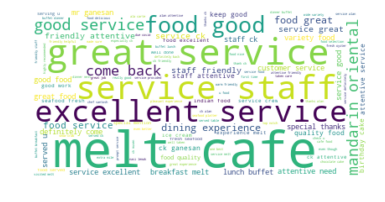

In [12]:
wc_fd = WordCloud(background_color="white")
wc_fd.generate_from_frequencies(FreqDist(top200_tokenized_by_rest_id[0]))
plt.imshow(wc_fd, interpolation='bilinear')
plt.axis("off")
plt.show()

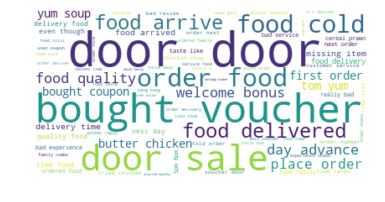

In [13]:
wc_fd = WordCloud(background_color="white")
wc_fd.generate_from_frequencies(FreqDist(bottom200_tokenized_by_rest_id[0]))
plt.imshow(wc_fd, interpolation='bilinear')
plt.axis("off")
plt.show()

In [14]:
### BIGRAMS
FreqDist(top200_tokenized_by_rest_id[0]).most_common(50)

[('melt cafe', 153),
 ('great service', 74),
 ('service staff', 64),
 ('excellent service', 56),
 ('food good', 49),
 ('good service', 44),
 ('mandarin oriental', 41),
 ('come back', 37),
 ('dining experience', 35),
 ('food great', 35),
 ('food service', 30),
 ('service ck', 27),
 ('staff friendly', 26),
 ('friendly attentive', 24),
 ('service great', 24),
 ('special thanks', 24),
 ('breakfast melt', 24),
 ('definitely come', 23),
 ('good food', 22),
 ('lunch buffet', 21),
 ('customer service', 20),
 ('mr ganesan', 20),
 ('service excellent', 20),
 ('variety food', 20),
 ('great food', 20),
 ('service good', 19),
 ('served u', 19),
 ('staff ck', 19),
 ('attentive need', 19),
 ('quality food', 18),
 ('attentive service', 18),
 ('keep good', 18),
 ('birthday cake', 17),
 ('ck ganesan', 17),
 ('staff attentive', 17),
 ('food quality', 17),
 ('experience melt', 17),
 ('good work', 17),
 ('ck attentive', 17),
 ('food excellent', 16),
 ('ice cream', 16),
 ('service crew', 16),
 ('indian food

In [15]:
FreqDist(bottom200_tokenized_by_rest_id[0]).most_common(50)

[('door door', 10),
 ('bought voucher', 9),
 ('door sale', 7),
 ('order food', 7),
 ('food cold', 7),
 ('food delivered', 6),
 ('food arrive', 6),
 ('food quality', 6),
 ('welcome bonus', 6),
 ('day advance', 6),
 ('place order', 5),
 ('bought coupon', 5),
 ('butter chicken', 5),
 ('first order', 5),
 ('tom yum', 5),
 ('yum soup', 5),
 ('delivery time', 5),
 ('food arrived', 5),
 ('missing item', 5),
 ('food delivery', 5),
 ('quality food', 4),
 ('delivery food', 4),
 ('next day', 4),
 ('even though', 4),
 ('time food', 4),
 ('bad experience', 4),
 ('cereal prawn', 4),
 ('food really', 4),
 ('next order', 4),
 ('bad service', 4),
 ('ordered food', 4),
 ('really bad', 4),
 ('5pm 8pm', 4),
 ('taste like', 4),
 ('time slot', 3),
 ('fried chicken', 3),
 ('voucher door', 3),
 ('order number', 3),
 ('customer service', 3),
 ('told order', 3),
 ('order next', 3),
 ('time range', 3),
 ('chicken chop', 3),
 ('bad review', 3),
 ('experience ohana', 3),
 ('used coupon', 3),
 ('ordered family', 3)

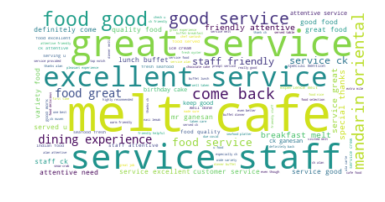

In [16]:
wc_fd = WordCloud(background_color="white")
wc_fd.generate_from_frequencies(FreqDist(top200_tokenized_by_rest_id[0]))
plt.imshow(wc_fd, interpolation='bilinear')
plt.axis("off")
plt.show()

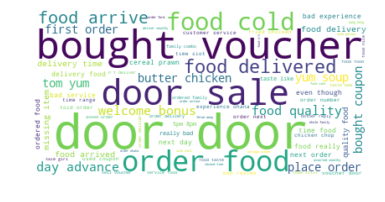

In [17]:
# A restaurant is skewing the word cloud due to them running a promotion for its crabs
# Remove 'House of Seafood' (rest_id d9752334, rank 9911) and re-run the word cloud

wc_fd = WordCloud(background_color="white")
wc_fd.generate_from_frequencies(FreqDist(bottom200_tokenized_by_rest_id[0]))
plt.imshow(wc_fd, interpolation='bilinear')
plt.axis("off")
plt.show()

In [18]:
# Bottom 200 Ranked Restaurants word frequency without 'House of Seafood'

FreqDist(bottom200_tokenized_by_rest_id[0]).most_common(50)

[('door door', 10),
 ('bought voucher', 9),
 ('door sale', 7),
 ('order food', 7),
 ('food cold', 7),
 ('food delivered', 6),
 ('food arrive', 6),
 ('food quality', 6),
 ('welcome bonus', 6),
 ('day advance', 6),
 ('place order', 5),
 ('bought coupon', 5),
 ('butter chicken', 5),
 ('first order', 5),
 ('tom yum', 5),
 ('yum soup', 5),
 ('delivery time', 5),
 ('food arrived', 5),
 ('missing item', 5),
 ('food delivery', 5),
 ('quality food', 4),
 ('delivery food', 4),
 ('next day', 4),
 ('even though', 4),
 ('time food', 4),
 ('bad experience', 4),
 ('cereal prawn', 4),
 ('food really', 4),
 ('next order', 4),
 ('bad service', 4),
 ('ordered food', 4),
 ('really bad', 4),
 ('5pm 8pm', 4),
 ('taste like', 4),
 ('time slot', 3),
 ('fried chicken', 3),
 ('voucher door', 3),
 ('order number', 3),
 ('customer service', 3),
 ('told order', 3),
 ('order next', 3),
 ('time range', 3),
 ('chicken chop', 3),
 ('bad review', 3),
 ('experience ohana', 3),
 ('used coupon', 3),
 ('ordered family', 3)

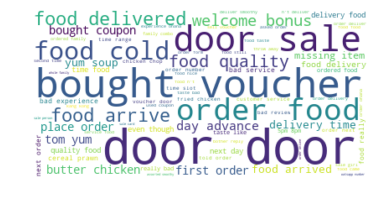

In [19]:
# Bottom 200 Ranked Restaurants wordcloud without 'House of Seafood'

wc_fd = WordCloud(background_color="white")
wc_fd.generate_from_frequencies(FreqDist(bottom200_tokenized_by_rest_id[0]))
plt.imshow(wc_fd, interpolation='bilinear')
plt.axis("off")
plt.show()

In [20]:
### TRIGRAMS
FreqDist(top200_tokenized_by_rest_id[0]).most_common(50)

[('melt cafe', 153),
 ('great service', 74),
 ('service staff', 64),
 ('excellent service', 56),
 ('food good', 49),
 ('good service', 44),
 ('mandarin oriental', 41),
 ('come back', 37),
 ('dining experience', 35),
 ('food great', 35),
 ('food service', 30),
 ('service ck', 27),
 ('staff friendly', 26),
 ('friendly attentive', 24),
 ('service great', 24),
 ('special thanks', 24),
 ('breakfast melt', 24),
 ('definitely come', 23),
 ('good food', 22),
 ('lunch buffet', 21),
 ('customer service', 20),
 ('mr ganesan', 20),
 ('service excellent', 20),
 ('variety food', 20),
 ('great food', 20),
 ('service good', 19),
 ('served u', 19),
 ('staff ck', 19),
 ('attentive need', 19),
 ('quality food', 18),
 ('attentive service', 18),
 ('keep good', 18),
 ('birthday cake', 17),
 ('ck ganesan', 17),
 ('staff attentive', 17),
 ('food quality', 17),
 ('experience melt', 17),
 ('good work', 17),
 ('ck attentive', 17),
 ('food excellent', 16),
 ('ice cream', 16),
 ('service crew', 16),
 ('indian food

In [21]:
FreqDist(bottom200_tokenized_by_rest_id[0]).most_common(50)

[('door door', 10),
 ('bought voucher', 9),
 ('door sale', 7),
 ('order food', 7),
 ('food cold', 7),
 ('food delivered', 6),
 ('food arrive', 6),
 ('food quality', 6),
 ('welcome bonus', 6),
 ('day advance', 6),
 ('place order', 5),
 ('bought coupon', 5),
 ('butter chicken', 5),
 ('first order', 5),
 ('tom yum', 5),
 ('yum soup', 5),
 ('delivery time', 5),
 ('food arrived', 5),
 ('missing item', 5),
 ('food delivery', 5),
 ('quality food', 4),
 ('delivery food', 4),
 ('next day', 4),
 ('even though', 4),
 ('time food', 4),
 ('bad experience', 4),
 ('cereal prawn', 4),
 ('food really', 4),
 ('next order', 4),
 ('bad service', 4),
 ('ordered food', 4),
 ('really bad', 4),
 ('5pm 8pm', 4),
 ('taste like', 4),
 ('time slot', 3),
 ('fried chicken', 3),
 ('voucher door', 3),
 ('order number', 3),
 ('customer service', 3),
 ('told order', 3),
 ('order next', 3),
 ('time range', 3),
 ('chicken chop', 3),
 ('bad review', 3),
 ('experience ohana', 3),
 ('used coupon', 3),
 ('ordered family', 3)

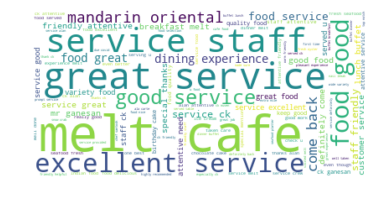

In [22]:
wc_fd = WordCloud(background_color="white")
wc_fd.generate_from_frequencies(FreqDist(top200_tokenized_by_rest_id[0]))
plt.imshow(wc_fd, interpolation='bilinear')
plt.axis("off")
plt.show()

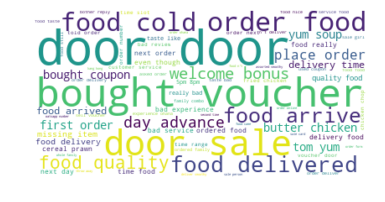

In [23]:
wc_fd = WordCloud(background_color="white")
wc_fd.generate_from_frequencies(FreqDist(bottom200_tokenized_by_rest_id[0]))
plt.imshow(wc_fd, interpolation='bilinear')
plt.axis("off")
plt.show()

In [24]:
# Reviews vs Ranking Scatterplot
es = Elasticsearch("localhost:9200", timeout=60, max_retries=10, retry_on_timeout=True)

top200_ranking = []
top200_SA_score = []

bottom200_ranking = []
bottom200_SA_score = []

res = es.search(index="agg-sentiment-analysis", doc_type='_doc', query={"match_all": {}}, size=10000)

for hit in res['hits']['hits']:
    
    restaurant_rank = hit['_source']['rank']
        
    if restaurant_rank <= 188 :
        top200_ranking.append(restaurant_rank)
        top200_SA_score.append(round(hit['_source']['agg_sentiment_score'], 2))
    else:
        bottom200_ranking.append(restaurant_rank)
        bottom200_SA_score.append(round(hit['_source']['agg_sentiment_score'], 2))

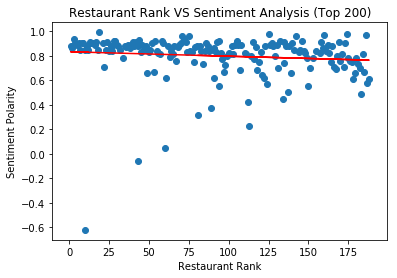

In [25]:
data_tuples = list(zip(top200_ranking, top200_SA_score))
df1 = pd.DataFrame(data_tuples, columns=['Rank','Agg_Sentiment_Polarity'])

lr = linear_model.LinearRegression()
lr.fit(df1[['Rank']], df1[['Agg_Sentiment_Polarity']])
slope = lr.coef_[0]
intercept = lr.intercept_
plt.plot(df1[['Rank']], slope*df1[['Rank']] + intercept, ls='-', marker=' ', color='red')
plt.scatter(df1['Rank'], df1['Agg_Sentiment_Polarity'])
matplotlib.pyplot.xlabel('Restaurant Rank')
matplotlib.pyplot.ylabel('Sentiment Polarity')
plt.title("Restaurant Rank VS Sentiment Analysis (Top 200)")
plt.show()

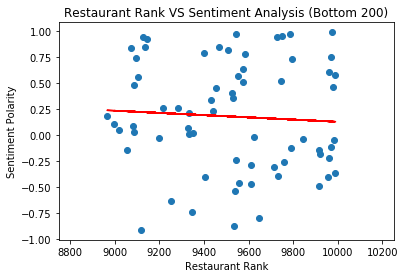

In [26]:
data_tuples2 = list(zip(bottom200_ranking, bottom200_SA_score))
df2 = pd.DataFrame(data_tuples2, columns=['Rank','Agg_Sentiment_Polarity'])

lr = linear_model.LinearRegression()
lr.fit(df2[['Rank']], df2[['Agg_Sentiment_Polarity']])
slope = lr.coef_[0]
intercept = lr.intercept_
plt.plot(df2[['Rank']], slope*df2[['Rank']] + intercept, ls='-', marker=' ', color='red')
plt.xlim((8750,10250))
plt.scatter(df2['Rank'], df2['Agg_Sentiment_Polarity'])
matplotlib.pyplot.xlabel('Restaurant Rank')
matplotlib.pyplot.ylabel('Sentiment Polarity')
plt.title("Restaurant Rank VS Sentiment Analysis (Bottom 200)")
plt.show()